### 1. Import dependencies

In [ ]:
!pip install tifffile tqdm numpy matplotlib
!pip install tqdm[notebook] ipywidgets
!pip install n2v
!pip install bioimageio.core


In [ ]:
from pathlib import Path

import os
import tifffile
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as pl

from n2v.models import N2VConfig, N2V
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

### 2. Define main parameters

In [11]:
# Folder containing noisy images
image_dir = r"D:/Data/Spheroids-Data-OCProject/Individual_Images/n2v_input/5slices"

# Name of the resulting model. If you already have the model with this name, it will be overwritten
model_name = 'denoising_5slices_n2v'

# Path where the model will be saved once trained
model_path = r'D:/GitHub/AI4Life-OC-3DM3/models'

# How many epochs (rounds) the network will be trained. 
# Preliminary results can already be observed after a few (10-30) epochs, but a full training should run for 100-200 epochs. 
number_of_epochs = 50

# N2V divides image into patches during training, this value is the size of the resulting patches
patch_shape=(64, 64)

# Input the percentage of your training dataset you want to use to validate the network during the training
percentage_validation = 10

# Limit the max number of generated patches in case of lower RAM
max_patches = 10000

In [ ]:
print("Path exists:", os.path.exists(image_dir))
print("Files in folder:")

Path exists: True
Files in folder:
['l_2_2_20X-03-Scene-01.ome_nuclei_TYX_5z.tif', 'l_2_2_20X-03-Scene-02.ome_nuclei_TYX_5z.tif', 'l_2_2_20X-03-Scene-03.ome_nuclei_TYX_5z.tif']


In [13]:
datagen = N2V_DataGenerator()
images = datagen.load_imgs_from_directory(directory=image_dir, filter='*.tif', dims='TYX')
print(f"Found {len(images)} image(s)")

for i, img in enumerate(images):
    print(f"Image {i}: shape = {img.shape}, dtype = {img.dtype}")

Found 3 image(s)
Image 0: shape = (58, 1368, 1444, 1), dtype = float32
Image 1: shape = (58, 1368, 1444, 1), dtype = float32
Image 2: shape = (58, 1368, 1444, 1), dtype = float32


### 3. Create data generator

In [14]:
patches = datagen.generate_patches_from_list(images, shape=patch_shape)
patches = patches[:max_patches]

total_number_of_patches = len(patches)
num_training_patches = total_number_of_patches - int(total_number_of_patches * (percentage_validation / 100))
X = patches[:num_training_patches]
X_val = patches[num_training_patches:]

Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
Generated patches: (3696, 64, 64, 1)
G

In [15]:
print(f"Loaded {len(images)} image(s)")
print(f"Shape of first image: {images[0].shape}")

Loaded 3 image(s)
Shape of first image: (58, 1368, 1444, 1)


### 4. Define model

In [16]:
config = N2VConfig(
    X, 
    blurpool=True, # Applies anti-aliasing in the downsampling layers
    skip_skipone=True, # Adds extra residual connection to stabilize training for noisy data
    unet_residual=False, # Disables residual prediction
    n2v_manipulator='median', # replaces center pixel with median of its neighbors
    unet_kern_size=3, 
    unet_n_first=64,      
    unet_n_depth=3, 
    train_steps_per_epoch=int(X.shape[0]/128), 
    train_epochs=number_of_epochs, 
    train_loss='mse', 
    batch_norm=True, 
    train_batch_size=128, 
    n2v_perc_pix=0.198, # nearly 20% pixels will be masked and predicted - common values 0.1-0.3
    n2v_patch_shape=patch_shape, 
    n2v_neighborhood_radius=5, 
    single_net_per_channel=False
)

model = N2V(config=config, name=model_name, basedir=model_path)

### 5. Train and save model

In [ ]:
history = model.train(X, X_val)

In [19]:
model.export_TF(
    name='N2V', 
    description="", 
    authors=[""],
    test_img=X[0], axes='YXC',
    patch_shape=patch_shape
)

1/1 [==============================] - 0s 10ms/step


INFO:tensorflow:Assets written to: D:\GitHub\AI4Life-OC-3DM3\models\denoising_5slices_n2v\tf_model\assets


INFO:tensorflow:Assets written to: D:\GitHub\AI4Life-OC-3DM3\models\denoising_5slices_n2v\tf_model\assets


ModuleNotFoundError: No module named 'bioimageio.core.build_spec'

### 6. Plot training and validation loss

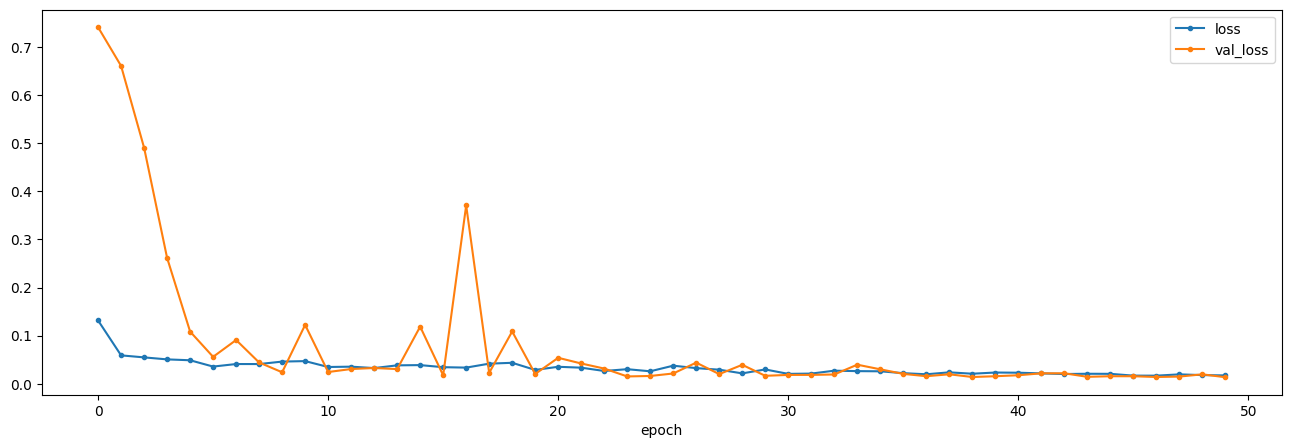

In [20]:
import matplotlib.pyplot as plt
from csbdeep.utils import plot_history

plt.figure(figsize=(16, 5))
plot_history(history, ['loss', 'val_loss']);

### 7. Prediction

In [28]:
data_folder = r"D:/Data/Spheroids-Data-OCProject/Individual_Images/n2v_input/5slices" # path to the data you want to predict

data_filter = "*.tif" 

output_postfix = "denoised" # results will be saved in the same folder, with this postfix added to the name

# If you want to predict with a different model,
# uncomment this lines and add a path to the model:

# model_name = "custom model name"
# model_path = "custom model path"

In [31]:
model = N2V(
    config=None, 
    name=model_name, 
    basedir=model_path
)

samples = sorted(Path(data_folder).glob(data_filter))

if len(samples) == 0:
    print(f"No data found in folder: {data_folder}")

for sample in tqdm(samples):
    image = tifffile.imread(sample)

    # If shape is (T, Y, X), add a singleton channel → (T, Y, X, 1)
    if image.ndim == 3:
        image = image[..., np.newaxis]
    
    result = []
    for timepoint in image:
        pred = model.predict(timepoint, axes='YXC')
        result.append(pred)
        
    # Write result with same shape as original
    result = np.squeeze(np.stack(result))  # (T, Y, X)

    name = sample.stem
    result_path = sample.parent / f"{sample.stem}_{output_postfix}.tif"
    # Save it without adding channel or flipping axes
    tifffile.imwrite(result_path, result.astype(np.float32), imagej=True, metadata={'axes': 'TYX'})

Loading network weights from 'weights_best.h5'.


  0%|          | 0/6 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 132ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 11ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 16ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 10ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 12ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 13ms/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 12ms/step
The input image is of type uint16 and will be casted to float32 for predict

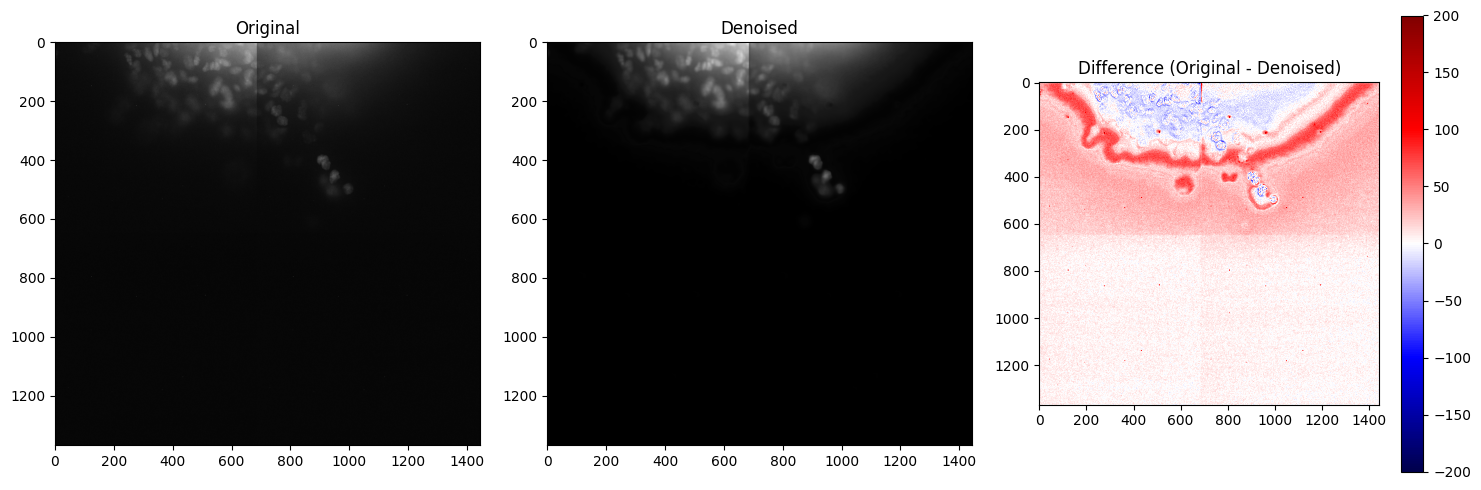

In [36]:
import matplotlib.pyplot as plt

original = tifffile.imread("D:/Data/Spheroids-Data-OCProject/Individual_Images/n2v_input/5slices/l_2_2_20X-03-Scene-01.ome_nuclei_TYX_5z.tif")  # shape: T, Y, X
denoised = tifffile.imread("D:/Data/Spheroids-Data-OCProject/Individual_Images/n2v_input/5slices/l_2_2_20X-03-Scene-01.ome_nuclei_TYX_5z_denoised_denoised.tif")  # shape: T, Y, X

# Pick one timepoint (e.g., 20)
t = 20
diff = original[t].astype(np.float32) - denoised[t].astype(np.float32)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original[t], cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Denoised")
plt.imshow(denoised[t], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Difference (Original - Denoised)")
plt.imshow(diff, cmap='seismic', vmin=-200, vmax=200)  # 👈 tweak this
plt.colorbar()

plt.tight_layout()
plt.show()


In [38]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

psnr_val = psnr(original[t], denoised[t], data_range=original[t].max() - original[t].min())
ssim_val = ssim(original[t], denoised[t], data_range=original[t].max() - original[t].min())

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")

PSNR: 39.05 dB
SSIM: 0.9275
